In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
workingDirectory = '/home/h1bennet/strains_rna/results/K01_Strains_AMLN30weeks_Kupffer_RNA/'
dataDirectory = '/home/h1bennet/strains/data/RNA/AMLN_30week_kupffer/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferNASH/
 

# Import differential gene files for examination and plotting

## Write differential genes to list for metascape

In [47]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [48]:
strains = ['aj', 'balb', 'c57']
log2fc = 1
padj = 0.05
diffpath = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/'

In [49]:
gene_list_dict ={}

In [50]:
for strain in strains:
    # initialize gene lists
    g_intersect = set()
    g_union = set()
    for i in glob.glob(diffpath+strain+'*NASH.vs.*NASH*.txt'):
        print(i)
        df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)

        # select differential genes
        # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
        sig_genes = df.index[(df['padj'] < padj) & (df['log2FoldChange'] <= -log2fc)].to_list()
        
        # add to sets
        if len(g_union) == 0:
            g_union = set(sig_genes)
            g_intersect = set(sig_genes)
        else:
            g_union = g_union.union(sig_genes)
            g_intersect = g_intersect.intersection(sig_genes)
        
        # print('union set length:', print(len(g_union)))
        # print('intersection set length:', print(len(g_intersect)))
    
    # after getting union and intersection sets add to dict
    gene_list_dict[strain+'_union'] = list(g_union)
    gene_list_dict[strain+'_intersection'] = list(g_intersect)
        

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_NASH.vs.balbcj_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_NASH.vs.c57bl6j_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_NASH.vs.aj_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_NASH.vs.c57bl6j_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_NASH.vs.balbcj_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_NASH.vs.aj_NASH.scatter.txt


In [51]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_lsec_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()


aj_union
594 genes
aj_intersection
44 genes
balb_union
801 genes
balb_intersection
63 genes
c57_union
522 genes
c57_intersection
175 genes


# Plot potential nichenet ligands

In [52]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

Read in raw expression values

In [53]:
tpm_mat = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt',
                      sep='\t', index_col=0)
tpm_mat = tpm_mat.loc[:, tpm_mat.columns.str.contains('NASH')]

Read in nichenet ligands

In [54]:
ligands = pd.read_csv('/home/h1bennet/data/gene_lists/nichenet_ligands.txt',
                      sep='\t')['x'].str.capitalize().tolist()
ligands[:5]

['Cxcl1', 'Cxcl2', 'Cxcl3', 'Cxcl5', 'Ppbp']

### Intersection gene set

In [55]:
act = []
for key in gene_list_dict.keys():
    if 'intersection' in key:
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with ligands
act_ligands = act.intersection(ligands)

In [56]:
tpm_mat.columns

Index(['aj_NASH_rep1', 'aj_NASH_rep2', 'aj_NASH_rep3', 'aj_NASH_rep4',
       'balbcj_NASH_rep5', 'balbcj_NASH_rep6', 'balbcj_NASH_rep7',
       'c57bl6j_NASH_rep1', 'c57bl6j_NASH_rep2', 'c57bl6j_NASH_rep3',
       'c57bl6j_NASH_rep4'],
      dtype='object')

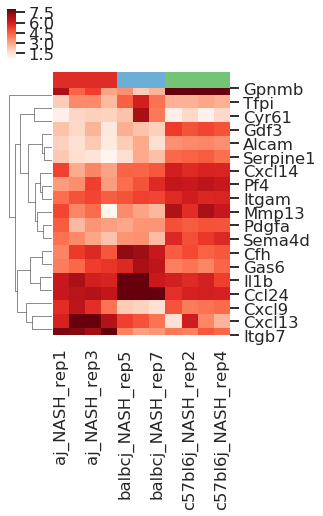

In [57]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#de2d26', '#de2d26', '#de2d26', '#de2d26',
                  '#6baed6', '#6baed6', '#6baed6',
                  '#74c476', '#74c476', '#74c476', '#74c476'],
    figsize=(4,6),
    yticklabels=1)

plt.savefig('./figures/diff_genes_intersection_ligands_clustermap.png', bbox_inches='tight')
# plt.close()

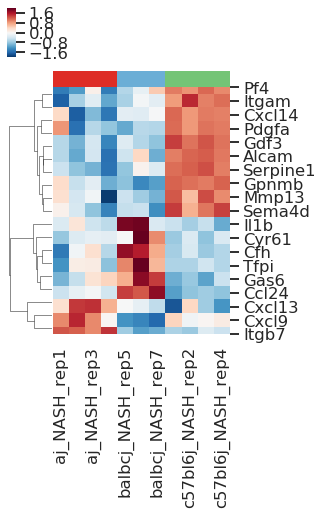

In [58]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    col_colors = ['#de2d26', '#de2d26', '#de2d26', '#de2d26',
                  '#6baed6', '#6baed6', '#6baed6',
                  '#74c476', '#74c476', '#74c476', '#74c476'],
    figsize=(4,6),
    yticklabels=1)

plt.savefig('./figures/diff_genes_intersection_ligands_clustermap_zscore.png', bbox_inches='tight')
# plt.close()

## Look at union gene set

In [59]:
act = []
for key in gene_list_dict.keys():
    if 'union' in key:
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with ligands
act_ligands = act.intersection(ligands)

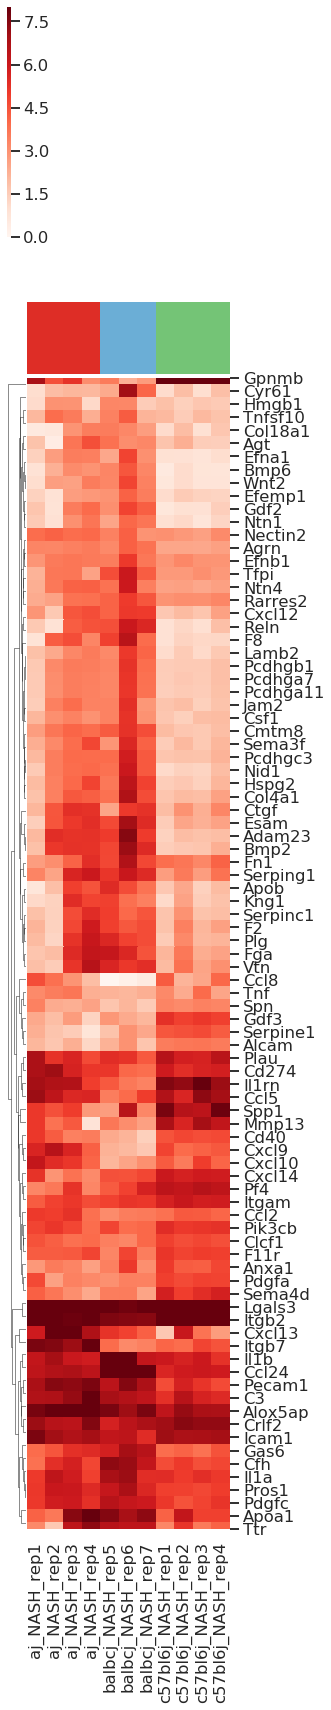

In [64]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#de2d26', '#de2d26', '#de2d26', '#de2d26',
                  '#6baed6', '#6baed6', '#6baed6',
                  '#74c476', '#74c476', '#74c476', '#74c476'],
    figsize=(4,28),
    yticklabels=1)

plt.savefig('./figures/diff_genes_union_ligands_clustermap.png', bbox_inches='tight')
# plt.close()

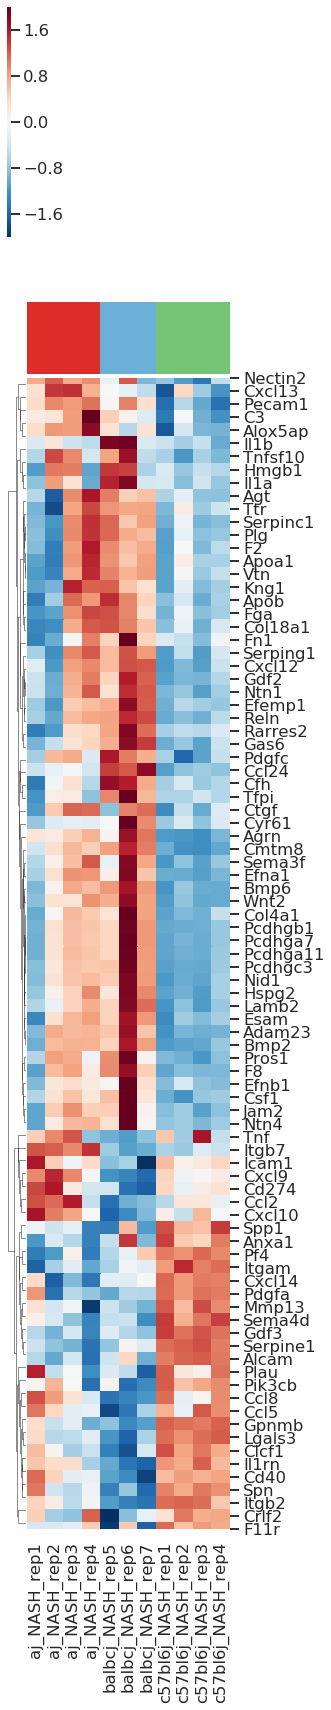

In [65]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    col_colors = ['#de2d26', '#de2d26', '#de2d26', '#de2d26',
                  '#6baed6', '#6baed6', '#6baed6',
                  '#74c476', '#74c476', '#74c476', '#74c476'],
    figsize=(4,28),
    yticklabels=1)

plt.savefig('./figures/diff_genes_union_ligands_clustermap_zscore.png', bbox_inches='tight')
# plt.close()